In [90]:
%matplotlib notebook
# starter code
import random
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm
import networkx as nx
from graph_tool.all import load_graph, shortest_distance, GraphView
from networkx.drawing.nx_agraph import graphviz_layout

from ic import simulate_cascade, observe_cascade, get_gvs, get_o2src_time, get_infection_time, gen_nontrivial_cascade
from utils import get_rank_index

seed = 123456
random.seed(seed)
np.random.seed(seed)

gtype = 'grid'
g = load_graph('data/{}/2-6/graph.gt'.format(gtype))
gnx = nx.read_graphml('data/{}/2-6/graph.graphml'.format(gtype))
gnx = nx.relabel_nodes(gnx, {i: int(i) for i in gnx.nodes_iter()})
N1, N2 = 100, 100
p, q = 0.5, 0.2

gvs = get_gvs(g, p, N2)
pos = graphviz_layout(gnx, root=0)

In [99]:
from steiner_tree import sample_consistent_cascade, max_infection_time

In [92]:
infection_times, source, obs_nodes = gen_nontrivial_cascade(g, p, q)

<IPython.core.display.Javascript object>


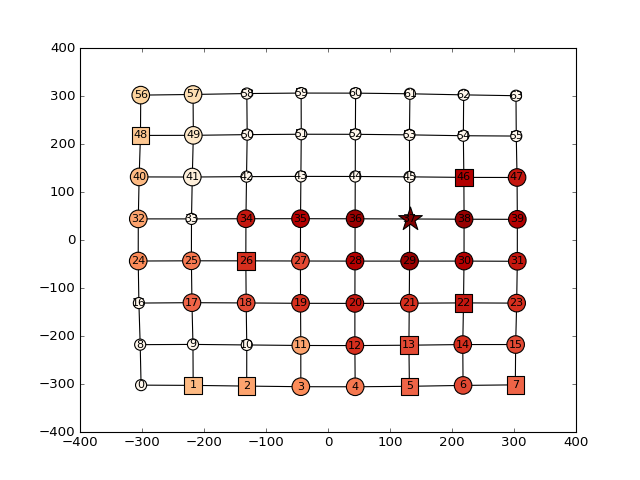

In [93]:
from plot_utils import plot_snapshot
plot_snapshot(gnx, pos, infection_times, queried_nodes=obs_nodes, source_node=source, with_labels=True)

In [75]:
target = 13
length = 14
cand_source = 0
forbidden_nodes = [o for o in obs_nodes
                   if infection_times[o] >= infection_times[target] and o != target]    
for p in all_simple_paths_of_length(g, source, target,
                                    length=length, 
                                    forbidden_nodes=forbidden_nodes,
                                    debug=False):
    print(p)
    assert len(p) - 1 == length, '{} != {}'.format(len(p)-1, length)
    for u, v in zip(p[:-1], p[1:]):
        assert g.edge(u, v) is not None
    for u in p:
        assert u not in forbidden_nodes
    assert p[0] == source
    assert p[-1] == target
    
    break

In [94]:
from numpy.testing import assert_array_equal
remaining_nodes = set(np.arange(g.num_vertices())) - set(obs_nodes)
cs2gv = {}
for cand_source in tqdm(remaining_nodes):
    gv = sample_consistent_cascade(g, obs_nodes, cand_source, infection_times, debug=False)
    if gv is not None:
        cs2gv[cand_source] = gv

100%|██████████| 55/55 [00:01<00:00, 39.06it/s]


In [20]:
def extract_edges(gt_edges):
    return [(int(u), int(v)) for u, v in gt_edges]

In [96]:
print(len(cs2gv))

26


In [103]:

print(infection_times[obs_nodes])
max_time = max_infection_time(g, infection_times, obs_nodes, n1, False)
pred_time = (get_infection_time(cs2gv[n1], n1) + max_time)[obs_nodes]
print(pred_time)

[ 5 10  6 11  6  9  2  4  3]
[ 5 10  6 11  6  9  2  4  3]


<IPython.core.display.Javascript object>


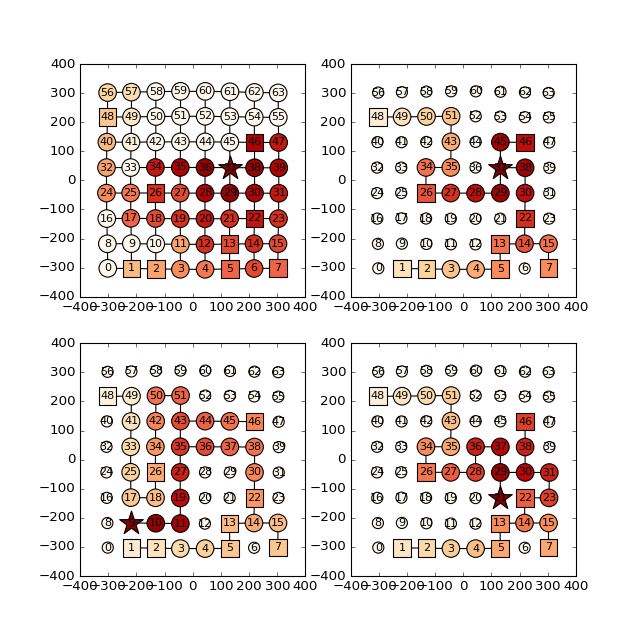

[37, 45, 46, 54, 62, 61, 60, 59, 58, 57, 56, 48]

In [95]:
import random
pool = [n for n in list(remaining_nodes - {source}) if n in cs2gv]
random.shuffle(pool)
n1, n2 = pool[:2]
fig, ax = plt.subplots(2, 2, figsize=(8, 8))
plot_snapshot(gnx, pos, infection_times, queried_nodes=obs_nodes, source_node=source, with_labels=True, ax=ax[0, 0])
plot_snapshot(gnx, pos, get_infection_time(cs2gv[source], source), queried_nodes=obs_nodes, source_node=source, with_labels=True,
              ax=ax[0, 1],
              edges=extract_edges(cs2gv[source].edges()))
plot_snapshot(gnx, pos, get_infection_time(cs2gv[n1], n1), queried_nodes=obs_nodes, source_node=n1, with_labels=True, ax=ax[1, 0],
              edges=extract_edges(cs2gv[n1].edges()))
plot_snapshot(gnx, pos, get_infection_time(cs2gv[n2], n2), queried_nodes=obs_nodes, source_node=n2, with_labels=True, ax=ax[1, 1],
              edges=extract_edges(cs2gv[n2].edges()))
[37, 45, 46, 54, 62, 61, 60, 59, 58, 57, 56, 48]

In [106]:
sorted_cs = list(sorted(cs2gv, key=lambda cs: cs2gv[cs].num_edges()))
print([cs2gv[cs].num_edges() for cs in sorted_cs])
print(sorted_cs)
print(source)

[25, 25, 27, 27, 28, 28, 29, 29, 30, 30, 31, 32, 32, 33, 33, 33, 34, 34, 34, 34, 35, 36, 36, 37, 37, 38]
[30, 37, 29, 36, 21, 28, 20, 35, 12, 34, 27, 4, 19, 11, 18, 33, 3, 10, 17, 25, 9, 8, 32, 0, 24, 16]
37
